In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from skimage.draw import draw
from scipy import interpolate
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'diam_ca100': 25*u.mm,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm,
             'label':'1in'} # useful for PSD

nt_ptt = 3
psd_folder = 'zygo_data/flat_mirrors/mvls_psd/'

# open the file
fileloc = 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
psd_fits = fits.open(psd_folder+fileloc)[0]
psd_avg = psd_fits.data * (u.nm*u.mm)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = psd_hdr['delta_k']/u.mm
opt_parms['diam_ca'] = psd_hdr['diam_ca']*u.mm
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 58 ms, sys: 3.91 ms, total: 61.9 ms
Wall time: 62 ms


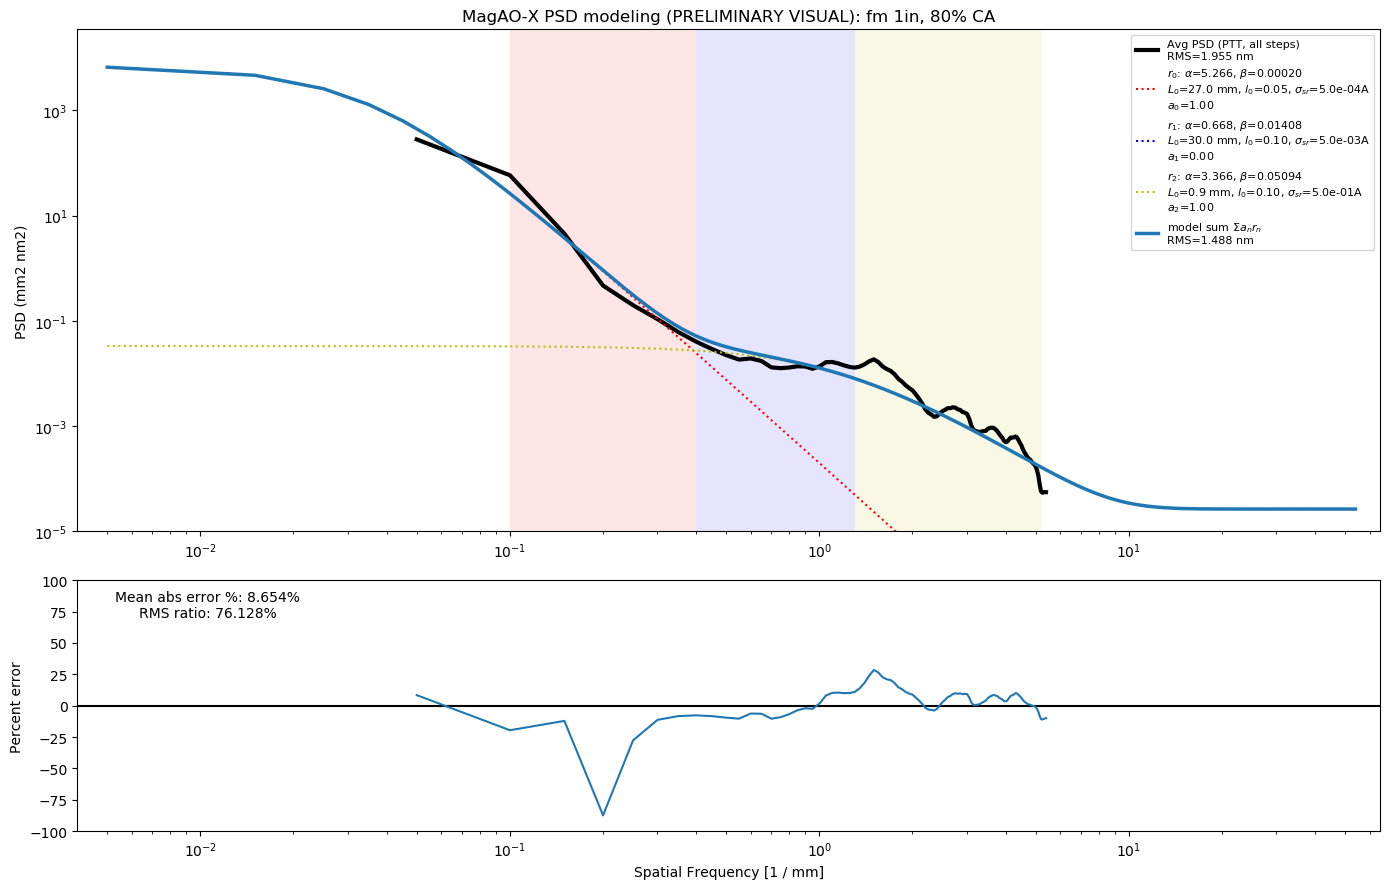

In [9]:
i_start = [1, 7, 25]
i_end = i_start[1:]
i_end.append(len(avg_psd.k_radial)-5)

lo = [0.05, 0.1, 0.1]
L0 = [27*u.mm, 30*u.mm, 0.88*u.mm]
rms_sr = [0.00005*u.nm, 0.0005*u.nm, 0.05*u.nm]
psd_weight = [1.0, 0.0, 1.0]
mdl_set, model_sum = psd.apply_model(i_start, i_end, lo, L0, rms_sr, psd_weight, avg_psd, opt_parms)
psd.plot_model(mdl_set, model_sum, avg_psd, opt_parms)

In [5]:
# Save the data as a pickle
psd_parm = []
for j in range(0, len(mdl_set)):
    parameters = [mdl_set[j].alpha, mdl_set[j].beta, mdl_set[j].L0, mdl_set[j].lo, mdl_set[j].bsr]
    psd_parm.append(parameters)
    
psd_dict = {'psd_fm1in': psd_parm,
            'psd_fm1in_weight': psd_weight}

# save the directory as a pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_{0}.pickle'.format(psd_parms['label'])
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

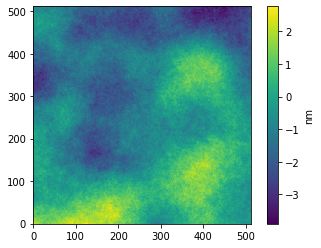

In [7]:
# Test what the randomized surface looks like
sg = psd.surfgen(dx=6.1524325E-02*u.mm, npix_diam=512, oversamp=2048)
sg.calc_psd(psd_parm=psd_parm, psd_weight=psd_scl[0])
sg.build_surf(opd_reflect=False)

plt.imshow(sg.surface.value, origin='lower')
plt.colorbar().set_label(sg.surface.unit)

## Regional mapping
Preliminary insight to visually choosing regions with fit best for simple model.

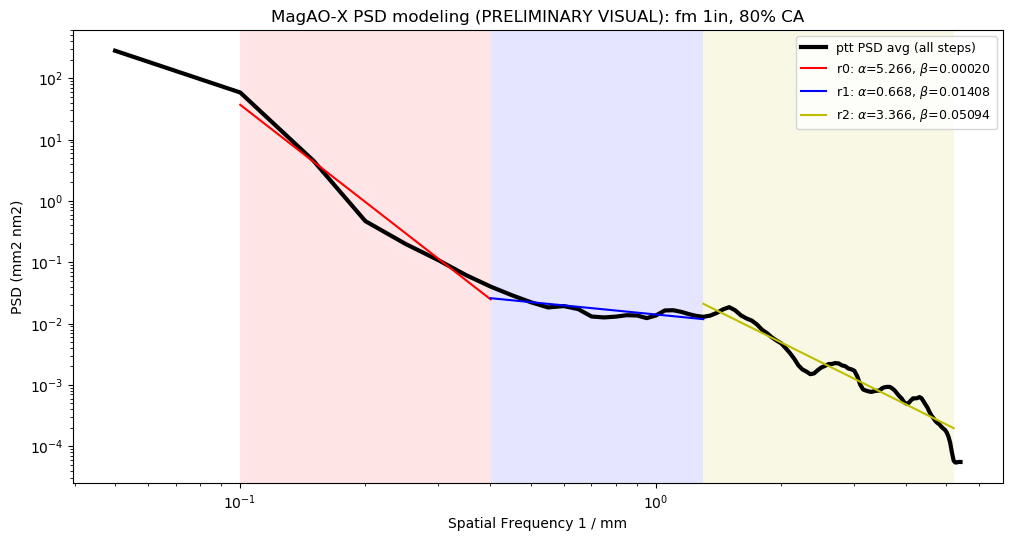

In [10]:
i_start = [1, 7, 25]
i_end = i_start[1:]
i_end.append(len(avg_psd.k_radial)-5)

mdl_simp = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j)
    mdl.load_parm(ind_range=[i_start[j], i_end[j]], psd_obj=avg_psd)
    mdl.solve_lsf()
    mdl.calc_model_simple(k_range=mdl.k_data)
    mdl_simp.append(mdl)

alpha_tone = 0.1
color_list=['r', 'b','y', 'g']
plt.figure(figsize=[12,6],dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal, 'k', linewidth=3, label='ptt PSD avg (all steps)')
for j in range(0, len(i_start)):
    plt.loglog(mdl_simp[j].k_data.value, mdl_simp[j].psd_simple.value, color_list[j], linewidth=1.5,
               label='r{0}: {1}={2:.3f}, {3}={4:.5f}'.format(mdl_simp[j].region_num, r'$\alpha$', mdl_simp[j].alpha, r'$\beta$', mdl_simp[j].beta.value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, 
                facecolor=color_list[j], alpha=alpha_tone)
plt.xlabel('Spatial Frequency {0}'.format(opt_parms['dk'].unit))
plt.ylabel('PSD ({0})'.format(psd_avg.unit))
plt.title('MagAO-X PSD modeling (PRELIMINARY VISUAL): fm {0}, {1}% CA'.format(opt_parms['label'], opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))